# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Data Science Capstone by IBM/Coursera

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Introduction: Business Problem</a>

2.  <a href="#item2">Data</a>

3.  <a href="#item3">Methodology</a>

4.  <a href="#item4">Analysis</a>

5.  <a href="#item5">Results and Discussion</a>  
    
6.  <a href="#item5">Conclusion</a> 
    </font>
    </div>


## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a language school. Specifically, this report will be targeted to stakeholders interested in opening an **Language School** in **Madrid**, Spain.

Since there are lots of schools in Madrid we will try to detect **locations that are not already crowded with schools**.

We will leverage the data science techniques to come up with a few recommended suggestions on the best neighborhoods and locations to enable the stakeholders to reach a final decision on the best location.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decision are:
* number of existing schools in the neighborhood (any type of school)
* number of and distance to Language schools in the neighborhood, if any

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Berlin center will be obtained using **Google Maps API geocoding** of well known Berlin location (Alexanderplatz)

## 1. Importing relevant Python libraries for the assignment

In [47]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
from urllib.request import urlopen # library for working with URLs

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install geocoder
import geocoder
!pip install geopandas
import geopandas as gpd

!pip install shapely
from shapely import geometry
from shapely.geometry import shape, mapping, Point, Polygon, MultiPolygon, GeometryCollection

!pip install fiona
import fiona

!pip install --upgrade scikit-learn
!pip install yellowbrick
!pip install descartes
!pip install folium
import folium # map rendering library
!pip install pickle-mixin
import pickle

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

from sklearn import metrics 
from scipy.spatial.distance import cdist

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

  Using cached https://files.pythonhosted.org/packages/e2/4c/6111b9a325f29527d7f262e2ee8c730d354b47a728d955e186dacad57a0d/scikit_learn-0.24.1-cp36-cp36m-manylinux2010_x86_64.whl
ERROR: yellowbrick 1.2.1 has requirement scikit-learn<0.24,>=0.20, but you'll have scikit-learn 0.24.1 which is incompatible.
  Found existing installation: scikit-learn 0.23.2
    Uninstalling scikit-learn-0.23.2:
      Successfully uninstalled scikit-learn-0.23.2
  Using cached https://files.pythonhosted.org/packages/5c/a1/273def87037a7fb010512bbc5901c31cfddfca8080bc63b42b26e3cc55b3/scikit_learn-0.23.2-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
Libraries imported.


## 2. Web scrape and reformat Wikipedia file into Pandas df format

In [48]:
# extract from the Wikipedia webpage all 130 neighbourhoods of Madrid into Pandas dataframe
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid"
response = requests.get(url)
lines = response.content.decode('utf-8').splitlines()

len_lines = len(lines)

# datarow variables
dummy = "" # redundant variable
district_name = ""
number = ""
neighborhood = ""
postal_code = ""
latitude_val = ""
longitude_val = ""
start_index = 0
end_index = 0

# define the dataframe columns
column_names = ['District', 'Number', 'Neighborhood']

# instantiate the dataframe
madrid_data_wiki = pd.DataFrame(columns=column_names)

# loop through every line
for i in range(0, len_lines):
    line = lines[i]

    # extract the header columns data into headers array and
    if "</td></tr></tbody></table>" in line:
        dummy = ""
        break
    # append the datarow variables as entries into data array
    elif "</td></tr>" in line:
        # Retrieve the latitude and the longitude coordinates of each neighborhood
        if line.find("</tbody></table>") < 0 and neighborhood != "":
            if neighborhood == "Los Cármenes":
                index = neighborhood.find("Los ") + len("Los ")
                neighborhood = neighborhood[index:len(neighborhood)]
            madrid_data_wiki = madrid_data_wiki.append({'District': district_name,
                                                        'Number': number,
                                                        'Neighborhood': neighborhood}, ignore_index=True)
                                                        #'Postal Code': postal_code,
                                                        #'Latitude': latitude_val,
                                                        #'Longitude': longitude_val}, ignore_index=True)
    elif "<td rowspan=" in line:
        # extract district name
        if line.find(" title=") > -1:
            index = line.find(" title=") + len(" title=")
            rest = line[index:len(line)]
            if rest.find(">") > -1:
                index = rest.find(">") + len(">")
                rest = rest[index:len(rest)]
                if rest.find("<") > -1:
                    end_index = rest.find("<")
                    district_name = rest[0:end_index]
    elif "<td align=\"center\"><a href=" in line:
        # extract neighbourhood
        index = line.find("<td align=\"center\"><a href=") + len("<td align=\"center\"><a href=")
        rest = line[index:len(line)]
        if rest.find(" title=") > -1:
            index = rest.find(" title=") + len(" title=")
            rest = rest[index:len(line)]
            if rest.find(">") > -1:
                index = rest.find(">") + len(">")
                rest = rest[index:len(rest)]
                if rest.find("<") > -1:
                    end_index = rest.find("<")
                    neighborhood = rest[0:end_index]
    elif "<td align=\"center\">" in line:
        # extract district number
            if line.find("<td align=\"center\">") > -1 and line.find(" title=") < 0:
                start_index = line.find("<td align=\"center\">") + len("<td align=\"center\">")
                number = line[start_index:len(line)]
    else:
        dummy = ""

madrid_data_wiki

District Number                Neighborhood
0                 Centro     11                     Palacio
1                 Centro     12                 Embajadores
2                 Centro     13                      Cortes
3                 Centro     14                    Justicia
4                 Centro     15                 Universidad
..                   ...    ...                         ...
125  San Blas-Canillejas    208                 El Salvador
126              Barajas    211            Alameda de Osuna
127              Barajas    212                  Aeropuerto
128              Barajas    213  Casco Histórico de Barajas
129              Barajas    214                       Timón

[130 rows x 3 columns]

In [49]:
# Step 1 - downloaded the Madrid GeoJson file containing all MultiPolygon coordinates per Madrid neighbourhood into 
# local disk via following url link
# https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/madrid.geojson
# Step 2 - "converted" Madrid GeoJson file into Shapefiles file format via https://mapshaper.org website
# Step 3 - uploaded corresponding madrid.* files to Python kernel runtime to run this python code

# Read file from Shapefile
fp = "madrid.shp"
madrid_neighborhood_geodf = gpd.read_file(fp, encoding='utf-8')
madrid_neighborhood_geodf

name  cartodb_id                created_at  \
0                       Palacio           1  2013-12-02T07:16:22+0100   
1                   Embajadores           2  2013-12-02T07:16:22+0100   
2                        Cortes           3  2013-12-02T07:16:22+0100   
3                      Justicia           4  2013-12-02T07:16:22+0100   
4                   Universidad           5  2013-12-02T07:16:22+0100   
..                          ...         ...                       ...   
123            Alameda de Osuna         124  2013-12-02T07:16:22+0100   
124                  Aeropuerto         125  2013-12-02T07:16:22+0100   
125  Casco Histórico de Barajas         126  2013-12-02T07:16:22+0100   
126                       Timón         127  2013-12-02T07:16:22+0100   
127                  Corralejos         128  2013-12-02T07:16:22+0100   

                   updated_at  \
0    2013-12-02T07:16:22+0100   
1    2013-12-02T07:16:22+0100   
2    2013-12-02T07:16:22+0100   
3    2013-12-02T07:16:22+0100   
4    2013-12-02T07:16:22+0100   
..                        ...   
123  2013-12-02T07:16:22+0100   
124  2013-12-02T07:16:22+0100   
125  2013-12-02T07:16:22+0100   
126  2013-12-02T07:16:22+0100   
127  2013-12-02T07:16:22+0100   

                                              geometry  
0    POLYGON ((-3.70462 40.42147, -3.70503 40.42135...  
1    POLYGON ((-3.70262 40.41549, -3.70155 40.41510...  
2    POLYGON ((-3.69178 40.42052, -3.69166 40.42006...  
3    POLYGON ((-3.69836 40.42094, -3.69836 40.42094...  
4    POLYGON ((-3.70028 40.42119, -3.70353 40.42144...  
..                                                 ...  
123  POLYGON ((-3.59194 40.45123, -3.59194 40.45123...  
124  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  
125  POLYGON ((-3.58094 40.46887, -3.58026 40.46997...  
126  POLYGON ((-3.57958 40.48115, -3.58059 40.47826...  
127  POLYGON ((-3.58094 40.46887, -3.58120 40.46824...  

[128 rows x 5 columns]

In [50]:
madrid_neighborhood = madrid_neighborhood_geodf[['name', 'geometry']].copy()
madrid_neighborhood.columns = ('Neighborhood', 'Geometry')
madrid_neighborhood['Neighborhood'] = madrid_neighborhood_geodf['name'].str.title()
madrid_neighborhood.tail()

Neighborhood  \
123            Alameda De Osuna   
124                  Aeropuerto   
125  Casco Histórico De Barajas   
126                       Timón   
127                  Corralejos   

                                              Geometry  
123  POLYGON ((-3.59194 40.45123, -3.59194 40.45123...  
124  POLYGON ((-3.53038 40.44818, -3.53179 40.44783...  
125  POLYGON ((-3.58094 40.46887, -3.58026 40.46997...  
126  POLYGON ((-3.57958 40.48115, -3.58059 40.47826...  
127  POLYGON ((-3.58094 40.46887, -3.58120 40.46824...

In [51]:
from shapely.wkt import loads as load_wkt

centroid_list = []

for polygon in madrid_neighborhood_geodf["geometry"]:
    box_str = str(polygon)
    p1 = load_wkt(box_str)
    point = p1.centroid
#     print(type(p1.centroid.x))
#     print(p1.centroid.y)
    centroid_list.append((p1.centroid.y, p1.centroid.x))

lat_centr, lon_centr = zip(*centroid_list)

madrid_neighborhood['Latitude'] = lat_centr
madrid_neighborhood['Longitude'] = lon_centr

df_madrid_complete = madrid_neighborhood
df_madrid_complete.head()

Neighborhood                                           Geometry   Latitude  \
0      Palacio  POLYGON ((-3.70462 40.42147, -3.70503 40.42135...  40.416600   
1  Embajadores  POLYGON ((-3.70262 40.41549, -3.70155 40.41510...  40.410419   
2       Cortes  POLYGON ((-3.69178 40.42052, -3.69166 40.42006...  40.416025   
3     Justicia  POLYGON ((-3.69836 40.42094, -3.69836 40.42094...  40.424839   
4  Universidad  POLYGON ((-3.70028 40.42119, -3.70353 40.42144...  40.426850   

   Longitude  
0  -3.712763  
1  -3.701153  
2  -3.695522  
3  -3.695351  
4  -3.705760

#### Use geopy library to get the latitude and longitude values of Madrid City.

In [52]:
address = 'Madrid, Spain'

geolocator = Nominatim(user_agent="mad_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Madrid City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Madrid City are 40.4167047, -3.7035825.


## 2. Explore Neighborhoods in Madrid

#### Define Foursquare Credentials and Version

In [53]:
CLIENT_ID = '4LJS4VEZUOLAZ350STJAD43WKIVBFXYONC22AVB0UQI3GGOM' # your Foursquare ID
CLIENT_SECRET = '0TDZ4MMLTKENSDANCCRBRGUGMZCYBB1CHJNAZIXUGF2QYPFC' # your Foursquare Secret
ACCESS_TOKEN = 'SXDX1VFQBLANOQFXFOSWE2AC5FNXN3UUSZEL3DE41CJ3J2OJ' # your FourSquare Access Token
VERSION = '20200605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on medical centers in each neighborhood.

We're interested in venues in 'food' category, but only those that are proper restaurants - coffe shops, pizza places, bakeries etc. are not direct competitors so we don't care about those. So we will include in out list only venues that have 'restaurant' in category name, and we'll make sure to detect and include all the subcategories of specific 'Italian restaurant' category, as we need info on Italian restaurants in the neighborhood.

In [54]:
def getNearbyVenues(names, latitudes, longitudes, radius):
    venues_list=[]
    
    print('Obtaining venues around candidate locations:', end='')
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&section=food&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(            
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        resp = requests.get(url).json()["response"]

        if "groups" in resp:
            results = resp['groups'][0]['items']
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'],
                v['venue']['location']['lat'],
                v['venue']['location']['lng'],
                v['venue']['categories'][0]['name']) for v in results])
        print(' .', end='')

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue',
                             'Venue Latitude', 
                             'Venue Longitude',
                             'Venue Category']

    print(' done.')    
    return(nearby_venues)

In [55]:
# Try to load from local file system in case we did this before
madrid_venues = []
loaded = False
try:
    with open('madrid_venues.pkl', 'rb') as f:
        madrid_venues = pickle.load(f)
    loaded = True

    # explode venues list into rows and columns in a Pandas dataframe for data manipulation
    madrid_venues = pd.DataFrame(data=madrid_venues, 
                                 columns=['Neighborhood', 
                                          'Neighborhood Latitude', 
                                          'Neighborhood Longitude', 
                                          'Venue',
                                          'Venue Latitude', 
                                          'Venue Longitude',
                                          'Venue Category'])

    df1 = pd.DataFrame(data=madrid_venues['Neighborhood'], columns=['Neighborhood'])
    df2 = pd.DataFrame(data=madrid_venues['Neighborhood Latitude'], columns=['Neighborhood Latitude'])
    df3 = pd.DataFrame(data=madrid_venues['Neighborhood Longitude'], columns=['Neighborhood Longitude'])
    df4 = pd.DataFrame(data=madrid_venues['Venue'], columns=['Venue'])
    df5 = pd.DataFrame(data=madrid_venues['Venue Latitude'], columns=['Venue Latitude'])
    df6 = pd.DataFrame(data=madrid_venues['Venue Longitude'], columns=['Venue Longitude'])
    df7 = pd.DataFrame(data=madrid_venues['Venue Category'], columns=['Venue Category'])
    dfs = [df1, df2, df3, df4, df5, df6, df7] # list of dataframes
 
    madrid_venues = pd.concat(dfs, axis=1)
    print('Madrid venues data loaded via local file system.')
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    #run to extract nearby venues on every neighborhood and create a new dataframe called madrid_venues.
    madrid_venues = getNearbyVenues(names=df_madrid_complete['Neighborhood'],
                                    latitudes=df_madrid_complete['Latitude'],
                                    longitudes=df_madrid_complete['Longitude'],
                                    radius=1000)
    
    # Let's persists this in local file system
    with open('madrid_venues.pkl', 'wb') as f:
        pickle.dump(madrid_venues, f)
    print('Madrid venues data loaded via Foursquare API.')

Obtaining venues around candidate locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.
Madrid venues data loaded via Foursquare API.


In [56]:
#s1 = "CafeterÃ­a Facultad de EducaciÃ³n UNED"
#s1.encode('raw_unicode_escape').decode('utf-8')
#print (s2)

In [57]:
import string

def is_printable(data):
    return all(c in string.printable for c in data)

def strip_unprintable(data):
    return ''.join(c for c in data if c in string.printable)

In [58]:
print(madrid_venues.shape)
madrid_venues.head()

(6272, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Palacio                40.4166               -3.712763   
1      Palacio                40.4166               -3.712763   
2      Palacio                40.4166               -3.712763   
3      Palacio                40.4166               -3.712763   
4      Palacio                40.4166               -3.712763   

                       Venue  Venue Latitude  Venue Longitude  \
0  la gastroteca de santiago       40.416639        -3.710944   
1        La Esquina del Real       40.417356        -3.710364   
2            Café de Oriente       40.418081        -3.711867   
3          Charlie Champagne       40.413936        -3.712647   
4                  Gyoza Go!       40.416179        -3.708612   

        Venue Category  
0           Restaurant  
1    French Restaurant  
2   Spanish Restaurant  
3           Restaurant  
4  Dumpling Restaurant

In [59]:
rest_unique = madrid_venues.groupby(['Venue',
                                     'Venue Latitude', 
                                     'Venue Longitude',
                                     'Venue Category']).size().reset_index(name='Counts') 
print(rest_unique.shape)
rest_unique.head(10)

(3196, 5)


Venue  Venue Latitude  Venue Longitude  Venue Category  Counts
0        (H)arina       40.446962        -3.694539          Bakery       2
1  100 Montaditos       40.347108        -3.677199  Sandwich Place       1
2  100 Montaditos       40.363294        -3.739031  Sandwich Place       1
3  100 Montaditos       40.381375        -3.663684  Sandwich Place       2
4  100 Montaditos       40.386003        -3.763597  Sandwich Place       1
5  100 Montaditos       40.393706        -3.796434  Sandwich Place       1
6  100 Montaditos       40.395526        -3.663918  Sandwich Place       2
7  100 Montaditos       40.404233        -3.609993  Sandwich Place       1
8  100 Montaditos       40.406980        -3.670893  Sandwich Place       2
9  100 Montaditos       40.411660        -3.658264  Sandwich Place       2

In [60]:
from shapely.geometry import shape, Point

rest_list = []

for ind1, rest in rest_unique.iterrows():
    point = Point(rest[["Venue Longitude"]].item(), rest[["Venue Latitude"]].item())
    for ind2, neighborhood in df_madrid_complete.iterrows():
        polygon = shape(neighborhood[["Geometry"]].item())
        """
        polygon.reset_index(drop=True, inplace=True)
        fig, ax = plt.subplots()
        #polys.plot(ax=ax, facecolor='gray');
        polygon.plot(ax=ax, facecolor='red');
        points = [point]
        xs = [point.x for point in points]
        ys = [point.y for point in points]
        plt.scatter(xs, ys)
        plt.tight_layout();
        """
        if (polygon.contains(point)):
            s = rest[["Venue"]].item()
            if is_printable(s) == False:
                s = strip_unprintable(s)

            frame = {'Neighborhood': neighborhood[["Neighborhood"]].item(),
                     'Neighborhood Latitude': neighborhood[["Latitude"]].item(),
                     'Neighborhood Longitude': neighborhood[["Longitude"]].item(),
                     #'Venue': rest[["Venue"]].item(), 
                     'Venue': s, 
                     'Venue Latitude': rest[["Venue Latitude"]].item(), 
                     'Venue Longitude': rest[["Venue Longitude"]].item(),
                     'Venue Category': rest[["Venue Category"]].item()
                    }
            rest_list.append(frame)

cn = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
      'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
madrid_venues_unique = pd.DataFrame(rest_list, columns = cn)
madrid_venues_unique.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Rios Rosas              40.443574               -3.696422   
1         Butarque              40.338369               -3.674994   
2       Buenavista              40.368278               -3.744770   
3  Palomeras Bajas              40.385940               -3.657573   
4          Aguilas              40.382983               -3.769777   

            Venue  Venue Latitude  Venue Longitude  Venue Category  
0        (H)arina       40.446962        -3.694539          Bakery  
1  100 Montaditos       40.347108        -3.677199  Sandwich Place  
2  100 Montaditos       40.363294        -3.739031  Sandwich Place  
3  100 Montaditos       40.381375        -3.663684  Sandwich Place  
4  100 Montaditos       40.386003        -3.763597  Sandwich Place

In [61]:
print(madrid_venues.shape)
print(madrid_venues_unique.shape)

(6272, 7)
(3178, 7)


In [62]:
rest_map = folium.Map([latitude, longitude], zoom_start=12)

for label, lat, lng in zip(madrid_venues_unique['Venue'], 
                           madrid_venues_unique['Venue Latitude'], 
                           madrid_venues_unique['Venue Longitude']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        popup=label,
        colur='red',
        fill=True,
        fill_color='green',
        fill_opacity=0.6,
        parse_html=False
    ).add_to(rest_map)

from IPython.display import display
display(rest_map)

In [63]:
resDF = madrid_venues_unique.groupby('Neighborhood').size().reset_index(name='Counts') 
resDF.head(10)

Neighborhood  Counts
0          Abrantes       8
1           Acacias      41
2           Adelfas      19
3        Aeropuerto      13
4           Aguilas      37
5  Alameda De Osuna      17
6           Almagro      33
7          Almenara      22
8       Almendrales      12
9            Aluche      23

In [64]:
#print('There are {} uniques categories.'.format(len(madrid_venues_unique['Venue Category'].unique())))
venueDF = madrid_venues_unique.groupby('Venue Category').size().reset_index(name='Counts')
venueDF.sort_values(by=['Counts'], ascending=False).head(10)

Venue Category  Counts
75        Spanish Restaurant     613
66                Restaurant     386
81          Tapas Restaurant     254
14                      Café     199
6                     Bakery     139
62               Pizza Place     131
45        Italian Restaurant     118
51  Mediterranean Restaurant      99
11              Burger Joint      89
69            Sandwich Place      83

## 3. Analyze Each Neighborhood

In [65]:
# one hot encoding
madrid_onehot = pd.get_dummies(madrid_venues_unique[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
madrid_onehot['Neighborhood'] = madrid_venues_unique['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [madrid_onehot.columns[-1]] + list(madrid_onehot.columns[:-1])
madrid_onehot = madrid_onehot[fixed_columns]

madrid_onehot.head()

Neighborhood  American Restaurant  Arepa Restaurant  \
0       Rios Rosas                    0                 0   
1         Butarque                    0                 0   
2       Buenavista                    0                 0   
3  Palomeras Bajas                    0                 0   
4          Aguilas                    0                 0   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop  Bakery  \
0                       0                 0          0           0       1   
1                       0                 0          0           0       0   
2                       0                 0          0           0       0   
3                       0                 0          0           0       0   
4                       0                 0          0           0       0   

   Bistro  Brazilian Restaurant  ...  Taco Place  Tapas Restaurant  Taverna  \
0       0                     0  ...           0                 0        0   
1       0                     0  ...           0                 0        0   
2       0                     0  ...           0                 0        0   
3       0                     0  ...           0                 0        0   
4       0                     0  ...           0                 0        0   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0                0                 0                   0                0   
1                0                 0                   0                0   
2                0                 0                   0                0   
3                0                 0                   0                0   
4                0                 0                   0                0   

   Vegetarian / Vegan Restaurant  Venezuelan Restaurant  Vietnamese Restaurant  
0                              0                      0                      0  
1                              0                      0                      0  
2                              0                      0                      0  
3                              0                      0                      0  
4                              0                      0                      0  

[5 rows x 91 columns]

In [66]:
madrid_onehot = pd.get_dummies(madrid_venues_unique['Venue Category'])
madrid_onehot.insert(loc=0, column='Neighborhood', value=madrid_venues_unique['Neighborhood'])
madrid_grouped = madrid_onehot.groupby('Neighborhood').mean().reset_index()
madrid_grouped.head(10)

Neighborhood  American Restaurant  Arepa Restaurant  \
0          Abrantes             0.000000               0.0   
1           Acacias             0.000000               0.0   
2           Adelfas             0.000000               0.0   
3        Aeropuerto             0.000000               0.0   
4           Aguilas             0.027027               0.0   
5  Alameda De Osuna             0.000000               0.0   
6           Almagro             0.030303               0.0   
7          Almenara             0.000000               0.0   
8       Almendrales             0.000000               0.0   
9            Aluche             0.000000               0.0   

   Argentinian Restaurant  Asian Restaurant  BBQ Joint  Bagel Shop    Bakery  \
0                     0.0          0.000000   0.000000         0.0  0.125000   
1                     0.0          0.048780   0.000000         0.0  0.073171   
2                     0.0          0.052632   0.000000         0.0  0.052632   
3                     0.0          0.000000   0.076923         0.0  0.153846   
4                     0.0          0.000000   0.000000         0.0  0.027027   
5                     0.0          0.000000   0.000000         0.0  0.117647   
6                     0.0          0.000000   0.000000         0.0  0.000000   
7                     0.0          0.000000   0.000000         0.0  0.000000   
8                     0.0          0.000000   0.083333         0.0  0.083333   
9                     0.0          0.000000   0.000000         0.0  0.043478   

     Bistro  Brazilian Restaurant  ...  Taco Place  Tapas Restaurant  Taverna  \
0  0.000000                 0.125  ...         0.0          0.000000      0.0   
1  0.000000                 0.000  ...         0.0          0.073171      0.0   
2  0.000000                 0.000  ...         0.0          0.105263      0.0   
3  0.000000                 0.000  ...         0.0          0.076923      0.0   
4  0.000000                 0.000  ...         0.0          0.135135      0.0   
5  0.058824                 0.000  ...         0.0          0.176471      0.0   
6  0.030303                 0.000  ...         0.0          0.030303      0.0   
7  0.000000                 0.000  ...         0.0          0.000000      0.0   
8  0.000000                 0.000  ...         0.0          0.000000      0.0   
9  0.000000                 0.000  ...         0.0          0.086957      0.0   

   Thai Restaurant  Theme Restaurant  Turkish Restaurant  Udon Restaurant  \
0         0.000000           0.00000                 0.0              0.0   
1         0.000000           0.02439                 0.0              0.0   
2         0.000000           0.00000                 0.0              0.0   
3         0.000000           0.00000                 0.0              0.0   
4         0.000000           0.00000                 0.0              0.0   
5         0.000000           0.00000                 0.0              0.0   
6         0.030303           0.00000                 0.0              0.0   
7         0.000000           0.00000                 0.0              0.0   
8         0.000000           0.00000                 0.0              0.0   
9         0.000000           0.00000                 0.0              0.0   

   Vegetarian / Vegan Restaurant  Venezuelan Restaurant  Vietnamese Restaurant  
0                            0.0                    0.0                    0.0  
1                            0.0                    0.0                    0.0  
2                            0.0                    0.0                    0.0  
3                            0.0                    0.0                    0.0  
4                            0.0                    0.0                    0.0  
5                            0.0                    0.0                    0.0  
6                            0.0                    0.0                    0.0  
7                            0.0                    0.0

In [67]:
# Select only the rows about restaurants.
# I suppose that our stakeholders doesn't looking to open a caffè or a bakery shop
madrid_grouped = madrid_grouped[['Neighborhood', 'Italian Restaurant', 'Pizza Place', 'Restaurant', 
                                 'Japanese Restaurant', 'Seafood Restaurant', 'Sandwich Place', 
                                 'Sushi Restaurant', 'Chinese Restaurant', 'Bistro', 'Burger Joint', 
                                 'Asian Restaurant', 'Diner', 'Vegetarian / Vegan Restaurant', 
                                 'Kebab Restaurant', 'Breakfast Spot', 'Steakhouse', 'Mediterranean Restaurant',
                                 'Gastropub', 'Fast Food Restaurant', 'Food Court', 'Indian Restaurant', 
                                 'Food Truck', 'Noodle House', 'Argentinian Restaurant', 'Ramen Restaurant', 
                                 'American Restaurant', 'Middle Eastern Restaurant', 'Fried Chicken Joint',
                                 'Greek Restaurant', 'Korean Restaurant', 'Mexican Restaurant', 
                                 'Falafel Restaurant', 'Salad Place', 'Tapas Restaurant'
                                ]]

madrid_grouped.head()

Neighborhood  Italian Restaurant  Pizza Place  Restaurant  \
0     Abrantes            0.000000     0.125000    0.000000   
1      Acacias            0.000000     0.097561    0.073171   
2      Adelfas            0.000000     0.000000    0.052632   
3   Aeropuerto            0.076923     0.000000    0.153846   
4      Aguilas            0.054054     0.027027    0.135135   

   Japanese Restaurant  Seafood Restaurant  Sandwich Place  Sushi Restaurant  \
0                  0.0            0.000000        0.125000           0.00000   
1                  0.0            0.000000        0.000000           0.02439   
2                  0.0            0.000000        0.052632           0.00000   
3                  0.0            0.000000        0.076923           0.00000   
4                  0.0            0.027027        0.054054           0.00000   

   Chinese Restaurant  Bistro  ...  Ramen Restaurant  American Restaurant  \
0            0.000000     0.0  ...               0.0             0.000000   
1            0.048780     0.0  ...               0.0             0.000000   
2            0.052632     0.0  ...               0.0             0.000000   
3            0.000000     0.0  ...               0.0             0.000000   
4            0.054054     0.0  ...               0.0             0.027027   

   Middle Eastern Restaurant  Fried Chicken Joint  Greek Restaurant  \
0                        0.0                  0.0               0.0   
1                        0.0                  0.0               0.0   
2                        0.0                  0.0               0.0   
3                        0.0                  0.0               0.0   
4                        0.0                  0.0               0.0   

   Korean Restaurant  Mexican Restaurant  Falafel Restaurant  Salad Place  \
0           0.000000                 0.0                 0.0          0.0   
1           0.000000                 0.0                 0.0          0.0   
2           0.052632                 0.0                 0.0          0.0   
3           0.000000                 0.0                 0.0          0.0   
4           0.000000                 0.0                 0.0          0.0   

   Tapas Restaurant  
0          0.000000  
1          0.073171  
2          0.105263  
3          0.076923  
4          0.135135  

[5 rows x 35 columns]

#### Put that into a _pandas_ dataframe

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
# create the new dataframe and display the top 10 venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
madrid_venues_sorted = pd.DataFrame(columns=columns)
madrid_venues_sorted['Neighborhood'] = madrid_grouped['Neighborhood']

for ind in np.arange(madrid_grouped.shape[0]):
    madrid_venues_sorted.iloc[ind, 1:] = return_most_common_venues(madrid_grouped.iloc[ind, :], num_top_venues)

madrid_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0     Abrantes          Burger Joint           Pizza Place   
1      Acacias           Pizza Place      Tapas Restaurant   
2      Adelfas      Tapas Restaurant        Breakfast Spot   
3   Aeropuerto            Restaurant                 Diner   
4      Aguilas      Tapas Restaurant            Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0  Fast Food Restaurant        Sandwich Place      Tapas Restaurant   
1            Restaurant    Chinese Restaurant      Asian Restaurant   
2            Restaurant     Korean Restaurant        Sandwich Place   
3      Tapas Restaurant        Breakfast Spot        Sandwich Place   
4  Fast Food Restaurant        Sandwich Place    Chinese Restaurant   

  6th Most Common Venue          7th Most Common Venue  \
0      Kebab Restaurant  Vegetarian / Vegan Restaurant   
1        Breakfast Spot           Fast Food Restaurant   
2      Asian Restaurant           Fast Food Restaurant   
3    Italian Restaurant            Fried Chicken Joint   
4          Burger Joint             Italian Restaurant   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                      Diner      Asian Restaurant     Chinese Restaurant  
1           Sushi Restaurant          Burger Joint             Steakhouse  
2         Chinese Restaurant           Pizza Place    Japanese Restaurant  
3  Middle Eastern Restaurant           Pizza Place     Falafel Restaurant  
4           Kebab Restaurant           Pizza Place     Seafood Restaurant

# Model Evaluation techniques
### Determine best technique for determining optimal value for k clusters in KMeans

In [70]:
madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

### Option 1 - Elbow method

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


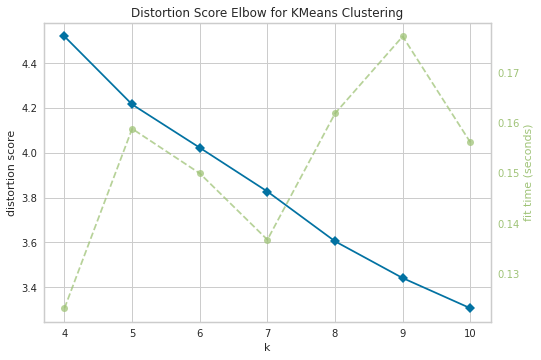

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [71]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,11))

visualizer.fit(madrid_grouped_clustering)        # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data

### Option 2 - Silhouette Visualizer

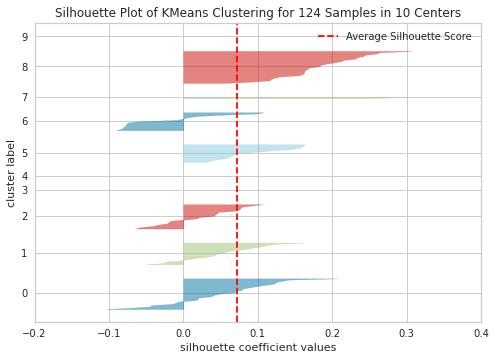

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 124 Samples in 10 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [72]:
model = KMeans(10, random_state=42)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(madrid_grouped_clustering) # Fit the data to the visualizer
visualizer.show()                         # Finalize and render the figure

### Option 3 - Intercluster Distance Maps

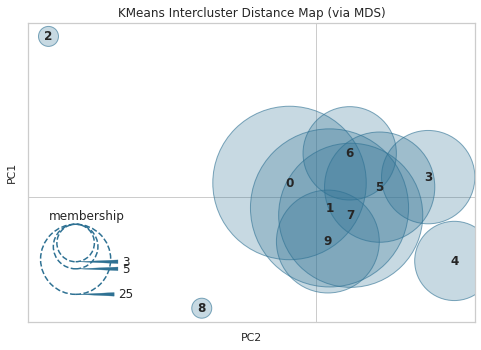

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [73]:
model = KMeans(10)
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(madrid_grouped_clustering)        # Fit the data to the visualizer
visualizer.show()                                # Finalize and render the figure

### Option 4 - Other clustering algorithms

In [74]:
# Try other clustering algorithms like Affinity Propagation which doesn’t require you to supply the value of K and 
# make it a part of the learning process. 
# These algorithms might not work for large datasets. 
# So, in some cases, we need to try them on a subset of data and then use the value in K-Means. 
# The Below code predicted XXX clusters that match the number of centers we have used.

In [75]:
# Creating Affinity Propagation model instance
affinity_propagation = AffinityPropagation(random_state=None, damping=0.90).fit(madrid_grouped_clustering)
# number of clusters found by Affinity propagation
len(affinity_propagation.cluster_centers_indices_)

23

### Conclusion - Apply the K-Means algorithm with K=7 to clusters our data points

## 4. Cluster Neighborhoods

In [76]:
# Run k-means to cluster the neighborhood into 6 clusters
# set number of clusters
kclusters = 6

#madrid_grouped_clustering = madrid_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(madrid_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 1, 1, 1, 5, 3, 3, 1], dtype=int32)

In [78]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood
# add clustering labels
# madrid_venues_sorted.drop(columns=['Cluster Labels'], inplace=True)
madrid_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#madrid_merged = madrid_data_wiki

# merge madrid_grouped with madrid_data_wiki to add latitude/longitude for each neighborhood
madrid_merged = df_madrid_complete.join(madrid_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
madrid_merged['Cluster Labels'] = madrid_merged['Cluster Labels'].fillna(0)
madrid_merged['Cluster Labels'] = madrid_merged['Cluster Labels'].astype(int)
madrid_merged.drop(columns='Geometry', inplace=True)

madrid_merged.head() # check the last columns!

Neighborhood   Latitude  Longitude  Cluster Labels 1st Most Common Venue  \
0      Palacio  40.416600  -3.712763               1      Tapas Restaurant   
1  Embajadores  40.410419  -3.701153               1      Tapas Restaurant   
2       Cortes  40.416025  -3.695522               5            Restaurant   
3     Justicia  40.424839  -3.695351               5            Restaurant   
4  Universidad  40.426850  -3.705760               1      Tapas Restaurant   

      2nd Most Common Venue          3rd Most Common Venue  \
0                Restaurant  Vegetarian / Vegan Restaurant   
1                Restaurant             Italian Restaurant   
2  Mediterranean Restaurant             Seafood Restaurant   
3                    Bistro             Italian Restaurant   
4                Restaurant                      Gastropub   

    4th Most Common Venue 5th Most Common Venue  \
0               Gastropub      Ramen Restaurant   
1          Breakfast Spot           Pizza Place   
2  Argentinian Restaurant   Japanese Restaurant   
3     American Restaurant             Gastropub   
4      Italian Restaurant           Pizza Place   

           6th Most Common Venue          7th Most Common Venue  \
0            Japanese Restaurant                         Bistro   
1       Mediterranean Restaurant             Seafood Restaurant   
2               Asian Restaurant  Vegetarian / Vegan Restaurant   
3                    Pizza Place                 Sandwich Place   
4  Vegetarian / Vegan Restaurant                 Breakfast Spot   

  8th Most Common Venue          9th Most Common Venue  \
0          Burger Joint         Argentinian Restaurant   
1      Sushi Restaurant                         Bistro   
2        Breakfast Spot               Tapas Restaurant   
3      Asian Restaurant  Vegetarian / Vegan Restaurant   
4    Mexican Restaurant            Japanese Restaurant   

          10th Most Common Venue  
0       Mediterranean Restaurant  
1  Vegetarian / Vegan Restaurant  
2             Italian Restaurant  
3       Mediterranean Restaurant  
4                          Diner

#### Create a map of Madrid with neighborhoods superimposed on top.

In [79]:
# create map
print(latitude)
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(madrid_merged['Latitude'], madrid_merged['Longitude'], madrid_merged['Neighborhood'], madrid_merged['Cluster Labels']):
    if np.isnan(cluster):
        cluster = 0
    else:
        cluster = int(cluster)

    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

40.4167047


## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [80]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 0, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

Latitude 2nd Most Common Venue     3rd Most Common Venue  \
15   40.415268      Tapas Restaurant                    Bistro   
44   40.482286                   NaN                       NaN   
45   40.479954      Tapas Restaurant                     Diner   
54   40.466434           Pizza Place                    Bistro   
60   40.403475           Pizza Place          Asian Restaurant   
62   40.386329                   NaN                       NaN   
81   40.385940      Tapas Restaurant      Fast Food Restaurant   
83   40.391795           Pizza Place  Mediterranean Restaurant   
86   40.409754  Fast Food Restaurant               Pizza Place   
90   40.406436           Pizza Place       Fried Chicken Joint   
109  40.356902    Chinese Restaurant              Burger Joint   
111  40.349710      Tapas Restaurant                    Bistro   
116  40.432120                   NaN                       NaN   
117  40.427314                   NaN                       NaN   
118  40.422404  Fast Food Restaurant          Tapas Restaurant   

      4th Most Common Venue 5th Most Common Venue  \
15           Breakfast Spot      Kebab Restaurant   
44                      NaN                   NaN   
45   Argentinian Restaurant            Restaurant   
54           Breakfast Spot      Kebab Restaurant   
60     Fast Food Restaurant    Seafood Restaurant   
62                      NaN                   NaN   
81                    Diner        Sandwich Place   
83       Mexican Restaurant        Breakfast Spot   
86       Chinese Restaurant    Italian Restaurant   
90           Breakfast Spot    Falafel Restaurant   
109              Restaurant        Breakfast Spot   
111          Breakfast Spot      Kebab Restaurant   
116                     NaN                   NaN   
117                     NaN                   NaN   
118     American Restaurant      Asian Restaurant   

             6th Most Common Venue          7th Most Common Venue  \
15   Vegetarian / Vegan Restaurant                          Diner   
44                             NaN                            NaN   
45              Chinese Restaurant               Asian Restaurant   
54   Vegetarian / Vegan Restaurant                          Diner   
60              Italian Restaurant             Falafel Restaurant   
62                             NaN                            NaN   
81             American Restaurant             Chinese Restaurant   
83              Falafel Restaurant                     Restaurant   
86                Greek Restaurant               Kebab Restaurant   
90                      Restaurant            Japanese Restaurant   
109               Kebab Restaurant  Vegetarian / Vegan Restaurant   
111  Vegetarian / Vegan Restaurant                          Diner   
116                            NaN                            NaN   
117                            NaN                            NaN   
118                   Burger Joint             Chinese Restaurant   

    8th Most Common Venue      9th Most Common Venue 10th Most Common Venue  
15       Asian Restaurant               Burger Joint     Chinese Restaurant  
44                    NaN                        NaN                    NaN  
45         Breakfast Spot         Italian Restaurant       Ramen Restaurant  
54       Asian Restaurant               Burger Joint     Chinese Restaurant  
60    Fried Chicken Joint  Middle Eastern Restaurant             Restaurant  
62                    NaN                        NaN                    NaN  
81             Restaurant             Breakfast Spot       Sushi Restaurant  
83    Japanese Restaurant         Seafood Restaurant         Sandwich Place  
86     Falafel Restaurant                 Restaurant    Japanese Restaurant  
90     Seafood Restaurant             Sandwich Place             Steakhouse  
109                 Diner           Asian Restaurant       Tapas Restaurant  
111      Asian Restaurant               Burger Joint     Ch

#### Cluster 2

In [81]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 1, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

Latitude     2nd Most Common Venue          3rd Most Common Venue  \
0    40.416600                Restaurant  Vegetarian / Vegan Restaurant   
1    40.410419                Restaurant             Italian Restaurant   
4    40.426850                Restaurant                      Gastropub   
5    40.418492                Restaurant         Argentinian Restaurant   
6    40.407370               Pizza Place                     Restaurant   
8    40.395942                Restaurant                   Burger Joint   
9    40.390017                Restaurant         Argentinian Restaurant   
10   40.397914                Restaurant             Chinese Restaurant   
13   40.405536                     Diner             Italian Restaurant   
16   40.420059                Restaurant             Seafood Restaurant   
20   40.426227          Tapas Restaurant             Seafood Restaurant   
21   40.425957       Japanese Restaurant                    Pizza Place   
23   40.433197        Seafood Restaurant               Tapas Restaurant   
24   40.434735          Tapas Restaurant                      Gastropub   
26   40.445400          Tapas Restaurant                     Restaurant   
27   40.449477                Restaurant           Fast Food Restaurant   
31   40.453627      Fast Food Restaurant                    Pizza Place   
36   40.460802               Pizza Place                   Burger Joint   
37   40.436165                Restaurant                      Gastropub   
39   40.434032                Restaurant       Mediterranean Restaurant   
41   40.443574                Restaurant             Italian Restaurant   
42   40.444073          Tapas Restaurant                    Pizza Place   
46   40.478334                Restaurant             Italian Restaurant   
47   40.482336                Restaurant       Mediterranean Restaurant   
48   40.501416          Tapas Restaurant                          Diner   
51   40.424809                Restaurant                      Gastropub   
52   40.429392                Restaurant                 Sandwich Place   
61   40.393093                Restaurant               Tapas Restaurant   
64   40.382983                Restaurant           Fast Food Restaurant   
67   40.397778                    Bistro                 Breakfast Spot   
69   40.380844               Pizza Place                     Restaurant   
76   40.390180        Seafood Restaurant               Tapas Restaurant   
92   40.427472                Restaurant                 Sandwich Place   
93   40.438193                Restaurant                 Breakfast Spot   
94   40.440498         Korean Restaurant                     Restaurant   
108  40.338369            Sandwich Place       Mediterranean Restaurant   
112  40.384662  Mediterranean Restaurant             Falafel Restaurant   
113  40.393589                Restaurant                    Pizza Place   
119  40.428697        Seafood Restaurant           Fast Food Restaurant   
123  40.457732                Restaurant             Chinese Restaurant   
124  40.477296                     Diner               Tapas Restaurant   

        4th Most Common Venue          5th Most Common Venue  \
0                   Gastropub               Ramen Restaurant   
1              Breakfast Spot                    Pizza Place   
4          Italian Restaurant                    Pizza Place   
5          Italian Restaurant       Mediterranean Restaurant   
6              Sandwich Place             Chinese Restaurant   
8                 Pizza Place             Seafood Restaurant   
9    Mediterranean Restaurant                 Sandwich Place   
10   Mediterranean Restaurant                 Breakfast Spot   
13          Indian Restaurant                    Pizza Place   
16   Mediterranean Restaurant                 Breakfast Spot   
20               Burger Joint                     Steakhouse   
21                 Restaurant             Italian Restaurant   
23          Indian Rest

#### Cluster 3

In [82]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 2, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

Latitude 2nd Most Common Venue 3rd Most Common Venue  \
43  40.554075      Tapas Restaurant                Bistro   

   4th Most Common Venue 5th Most Common Venue          6th Most Common Venue  \
43        Breakfast Spot      Kebab Restaurant  Vegetarian / Vegan Restaurant   

   7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
43                 Diner      Asian Restaurant          Burger Joint   

   10th Most Common Venue  
43     Chinese Restaurant

#### Cluster 4

In [83]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 3, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

Latitude 2nd Most Common Venue     3rd Most Common Venue  \
7    40.402248      Tapas Restaurant                Restaurant   
14   40.402297        Breakfast Spot                Restaurant   
18   40.412789      Asian Restaurant        Chinese Restaurant   
22   40.437515            Restaurant       Japanese Restaurant   
30   40.475494        Sandwich Place          Tapas Restaurant   
32   40.452697    Italian Restaurant                Restaurant   
33   40.461591    Italian Restaurant       Japanese Restaurant   
34   40.471839    Italian Restaurant            Sandwich Place   
35   40.468200      Tapas Restaurant        Mexican Restaurant   
38   40.435585        Sandwich Place          Tapas Restaurant   
49   40.497490          Burger Joint                Restaurant   
53   40.457129            Restaurant                Steakhouse   
56   40.470927          Burger Joint       American Restaurant   
58   40.402668  Fast Food Restaurant                     Diner   
59   40.410870            Restaurant                     Diner   
65   40.394683           Pizza Place      Fast Food Restaurant   
66   40.391410      Tapas Restaurant              Burger Joint   
68   40.385502    Seafood Restaurant          Tapas Restaurant   
70   40.368278    Italian Restaurant                Restaurant   
71   40.380159           Pizza Place      Fast Food Restaurant   
72   40.369812                Bistro            Breakfast Spot   
73   40.373392           Pizza Place                Restaurant   
75   40.384864    Chinese Restaurant                 Gastropub   
77   40.380551      Asian Restaurant          Tapas Restaurant   
78   40.379325          Noodle House                Restaurant   
80   40.391211  Fast Food Restaurant          Tapas Restaurant   
82   40.386422           Pizza Place      Fast Food Restaurant   
85   40.399705                 Diner          Tapas Restaurant   
88   40.413076  Fast Food Restaurant        Chinese Restaurant   
91   40.423657    Chinese Restaurant  Mediterranean Restaurant   
97   40.459227    Chinese Restaurant       Japanese Restaurant   
98   40.465452    Chinese Restaurant          Kebab Restaurant   
100  40.453692    Italian Restaurant              Burger Joint   
101  40.456896           Pizza Place        Chinese Restaurant   
102  40.464960        Breakfast Spot               Pizza Place   
105  40.494849        Sandwich Place        Italian Restaurant   
107  40.341950                Bistro            Breakfast Spot   
126  40.485583      Tapas Restaurant            Sandwich Place   

             4th Most Common Venue          5th Most Common Venue  \
7               Chinese Restaurant               Asian Restaurant   
14               Korean Restaurant                 Sandwich Place   
18              Mexican Restaurant               Kebab Restaurant   
22                Tapas Restaurant              Indian Restaurant   
30                    Burger Joint                          Diner   
32                     Pizza Place            Japanese Restaurant   
33              Chinese Restaurant               Asian Restaurant   
34                      Restaurant                 Breakfast Spot   
35        Mediterranean Restaurant              Korean Restaurant   
38                Asian Restaurant             Seafood Restaurant   
49              Seafood Restaurant             Italian Restaurant   
53            Fast Food Restaurant               Asian Restaurant   
56             Japanese Restaurant             Seafood Restaurant   
58             American Restaurant                   Burger Joint   
59                Tapas Restaurant                    Pizza Place   
65                Sushi Restaurant                   Burger Joint   
66              Falafel Restaurant             Mexican Restaurant   
68                     Pizza Place                     Restaurant   
70                  Sandwich Place               Asian Restaurant   
71                  Sandwich Place               Ta

#### Cluster 5

In [84]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 4, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

Latitude 2nd Most Common Venue 3rd Most Common Venue  \
114  40.410345      Tapas Restaurant                Bistro   

    4th Most Common Venue 5th Most Common Venue  \
114        Breakfast Spot      Kebab Restaurant   

             6th Most Common Venue 7th Most Common Venue  \
114  Vegetarian / Vegan Restaurant                 Diner   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
114          Burger Joint    Chinese Restaurant            Salad Place

#### Cluster 6

In [85]:
madrid_merged.loc[madrid_merged['Cluster Labels'] == 5, madrid_merged.columns[[1] + list(range(5, madrid_merged.shape[1]))]]

Latitude     2nd Most Common Venue     3rd Most Common Venue  \
2    40.416025  Mediterranean Restaurant        Seafood Restaurant   
3    40.424839                    Bistro        Italian Restaurant   
11   40.404691          Tapas Restaurant            Breakfast Spot   
12   40.400882               Pizza Place  Mediterranean Restaurant   
17   40.414929                 Gastropub  Mediterranean Restaurant   
19   40.425781          Tapas Restaurant       Japanese Restaurant   
25   40.446049               Pizza Place          Tapas Restaurant   
28   40.456546       Japanese Restaurant          Tapas Restaurant   
29   40.463944       American Restaurant          Tapas Restaurant   
40   40.434031       Japanese Restaurant  Mediterranean Restaurant   
50   40.535565                Restaurant          Tapas Restaurant   
55   40.469315                Restaurant                    Bistro   
57   40.455854        Italian Restaurant              Burger Joint   
63   40.369869              Burger Joint               Pizza Place   
74   40.371772          Tapas Restaurant        Falafel Restaurant   
79   40.375960                Restaurant        Chinese Restaurant   
84   40.400677  Mediterranean Restaurant        Chinese Restaurant   
87   40.411916                Restaurant            Breakfast Spot   
89   40.402597                Restaurant          Sushi Restaurant   
95   40.444044        Italian Restaurant               Pizza Place   
96   40.451873        Chinese Restaurant              Burger Joint   
99   40.477833        Italian Restaurant            Breakfast Spot   
103  40.473582          Tapas Restaurant                Food Truck   
104  40.477583                Food Truck          Tapas Restaurant   
106  40.342634  Mediterranean Restaurant              Burger Joint   
110  40.356973               Pizza Place          Tapas Restaurant   
115  40.436507            Sandwich Place  Mediterranean Restaurant   
120  40.446274            Breakfast Spot  Mediterranean Restaurant   
121  40.444442            Breakfast Spot               Pizza Place   
122  40.446471            Breakfast Spot                Restaurant   
125  40.475880            Breakfast Spot    Argentinian Restaurant   
127  40.465319               Pizza Place      Fast Food Restaurant   

      4th Most Common Venue     5th Most Common Venue  \
2    Argentinian Restaurant       Japanese Restaurant   
3       American Restaurant                 Gastropub   
11              Pizza Place            Sandwich Place   
12               Food Truck        Seafood Restaurant   
17   Argentinian Restaurant               Pizza Place   
19       Italian Restaurant  Mediterranean Restaurant   
25   Argentinian Restaurant          Sushi Restaurant   
28       Seafood Restaurant  Mediterranean Restaurant   
29              Pizza Place                     Diner   
40               Food Truck               Pizza Place   
50                   Bistro          Kebab Restaurant   
55           Breakfast Spot          Kebab Restaurant   
57       Falafel Restaurant        Mexican Restaurant   
63     Fast Food Restaurant          Tapas Restaurant   
74      American Restaurant                    Bistro   
79             Burger Joint            Breakfast Spot   
84              Pizza Place       Japanese Restaurant   
87     Fast Food Restaurant                Food Truck   
89         Tapas Restaurant              Burger Joint   
95           Sandwich Place      Fast Food Restaurant   
96   Argentinian Restaurant                 Gastropub   
99       Chinese Restaurant          Asian Restaurant   
103             Pizza Place            Sandwich Place   
104                  Bistro          Kebab Restaurant   
106          Breakfast Spot                     Diner   
110            Burger Joint            Breakfast Spot   
115          Breakfast Spot      Fast Food Restaurant   
120                  Bistro          Kebab Restaurant   
121    Fast Food Restaurant          Asian